# Predictive Maintenance using Bayesian Networks and Optimization
This project aims to minimize machine failures by combining Bayesian causal modeling and constrained optimization.

**Techniques used:**
- Bayesian Networks for reasoning
- Linear programming with constraints
- Visualization and summary reporting

In [1]:
import pandas as pd
df = "/content/ai4i2020.csv"
df = pd.read_csv(df)
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [2]:
df.info(), df.head(), df.isnull().sum(), df.duplicated().sum(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

(None,
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
 0                    1551         42.8                0                0    0   
 1                    1408         46.3                3                0    0   
 2                    1498         49.4                5                0    0   
 3                    1433         39.5                7                0    0   
 4                    1408         40.0                9                0    0   
 
    HDF  PWF  OSF  RNF  
 0    0    0    0    0  
 1    0  

In [3]:
df = pd.get_dummies(df, columns=['Type'], drop_first=True)


In [4]:
for col in ['UDI', 'Product_ID']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)


In [5]:
df.columns = [col.replace(" [K]", "").replace(" [rpm]", "").replace(" [Nm]", "").replace(" [min]", "").replace(" ", "_") for col in df.columns]


In [6]:
df[["Type_L", "Type_M"]] = df[["Type_L", "Type_M"]].astype(int)

+--------------------+------------------------+
| Machine_failure    |   phi(Machine_failure) |
+====================+========================+
| Machine_failure(0) |                 0.7302 |
+--------------------+------------------------+
| Machine_failure(1) |                 0.2698 |
+--------------------+------------------------+


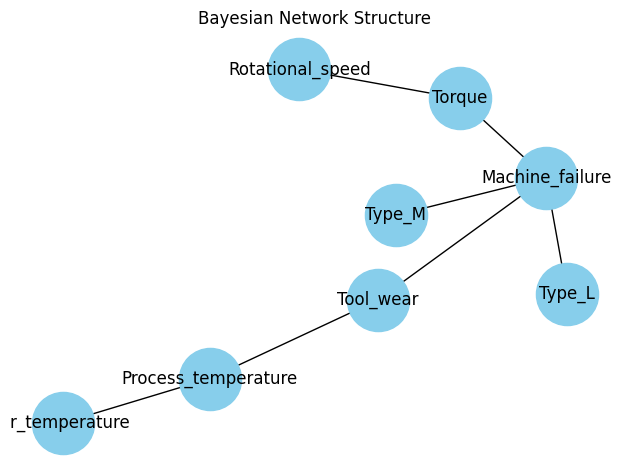

In [7]:
# %% Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer



# %% Drop unneeded columns
df.drop(columns=["Product_ID", "Type_Full"], inplace=True, errors='ignore')

# %% Discretize continuous features (3 bins: low/med/high)
continuous_cols = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df[continuous_cols] = discretizer.fit_transform(df[continuous_cols])
df[continuous_cols] = df[continuous_cols].astype(int)

# %% Define causal structure manually
model = DiscreteBayesianNetwork([
    ("Torque", "Machine_failure"),
    ("Tool_wear", "Machine_failure"),
    ("Rotational_speed", "Torque"),
    ("Air_temperature", "Process_temperature"),
    ("Process_temperature", "Tool_wear"),
    ("Type_L", "Machine_failure"),
    ("Type_M", "Machine_failure")
])


# %% Fit the CPDs using BayesianEstimator
model.fit(df, estimator=BayesianEstimator)
infer = VariableElimination(model)

# For example: Type_L machine with high torque and tool wear
query = infer.query(variables=["Machine_failure"], evidence={"Torque": 2, "Tool_wear": 2, "Type_L": 1})
print(query)


# %% Visualize network structure
graph = nx.DiGraph()
graph.add_edges_from(model.edges())

pos = nx.spring_layout(graph, seed=42)
nx.draw_networkx_nodes(graph, pos, node_size=2000, node_color='skyblue')
nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(graph, pos, font_size=12)

plt.title("Bayesian Network Structure")
plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# Scenario: Type_L machine, high torque and wear
query = infer.query(
    variables=["Machine_failure"],
    evidence={"Torque": 2, "Tool_wear": 2, "Type_L": 1}
)
print(query)


+--------------------+------------------------+
| Machine_failure    |   phi(Machine_failure) |
+====================+========================+
| Machine_failure(0) |                 0.7302 |
+--------------------+------------------------+
| Machine_failure(1) |                 0.2698 |
+--------------------+------------------------+


In [9]:
# Scenario: Type_M machine under same conditions
query = infer.query(
    variables=["Machine_failure"],
    evidence={"Torque": 2, "Tool_wear": 2, "Type_M": 1}
)
print(query)


+--------------------+------------------------+
| Machine_failure    |   phi(Machine_failure) |
+====================+========================+
| Machine_failure(0) |                 0.6703 |
+--------------------+------------------------+
| Machine_failure(1) |                 0.3297 |
+--------------------+------------------------+


In [10]:
scenarios = [
    {"label": "Type_M", "evidence": {"Torque": 2, "Tool_wear": 2, "Type_M": 1}},
    {"label": "Type_L", "evidence": {"Torque": 2, "Tool_wear": 2, "Type_L": 1}},
    {"label": "Type_H (default)", "evidence": {"Torque": 2, "Tool_wear": 2}}
]

for s in scenarios:
    result = infer.query(variables=["Machine_failure"], evidence=s["evidence"])
    print(f"{s['label']} → Failure: {result.values[1]:.4f}, No Failure: {result.values[0]:.4f}")


Type_M → Failure: 0.3297, No Failure: 0.6703
Type_L → Failure: 0.2698, No Failure: 0.7302
Type_H (default) → Failure: 0.1917, No Failure: 0.8083


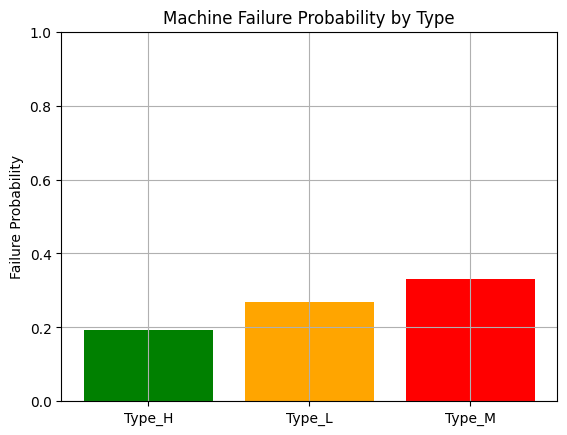

In [11]:
import matplotlib.pyplot as plt

types = ['Type_H', 'Type_L', 'Type_M']
failure_probs = [0.1917, 0.2698, 0.3297]

plt.bar(types, failure_probs, color=['green', 'orange', 'red'])
plt.ylabel("Failure Probability")
plt.title("Machine Failure Probability by Type")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


Optimization Problem
Objective:
Minimize expected number of machine failures, given the probabilities learned from your Bayesian network.

In [12]:
!pip install pulp

In [13]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value

# Failure probabilities from Bayesian inference
fail_prob = {
    'H': 0.1917,
    'L': 0.2698,
    'M': 0.3297
}

# Define the LP problem
prob = LpProblem("Minimize_Expected_Machine_Failures", LpMinimize)

# Decision variables: number of machines to deploy of each type
x_H = LpVariable('x_H', lowBound=0, cat='Integer')
x_L = LpVariable('x_L', lowBound=0, cat='Integer')
x_M = LpVariable('x_M', lowBound=0, cat='Integer')

# Objective: minimize total expected failures
prob += (
    fail_prob['H'] * x_H +
    fail_prob['L'] * x_L +
    fail_prob['M'] * x_M,
    "Total_Expected_Failures"
)

# Constraints
prob += x_H + x_L + x_M == 100  # Total machines to deploy
prob += x_H <= 40               # Max available Type_H
prob += x_L <= 30               # Max available Type_L
prob += x_M <= 30               # Max available Type_M

# Solve the problem
prob.solve()

# Output results
print("Optimal Machine Deployment:")
print(f"Type_H: {x_H.value()} machines")
print(f"Type_L: {x_L.value()} machines")
print(f"Type_M: {x_M.value()} machines")
print(f"Minimum Expected Failures: {value(prob.objective):.4f}")


Optimal Machine Deployment:
Type_H: 40.0 machines
Type_L: 30.0 machines
Type_M: 30.0 machines
Minimum Expected Failures: 25.6530


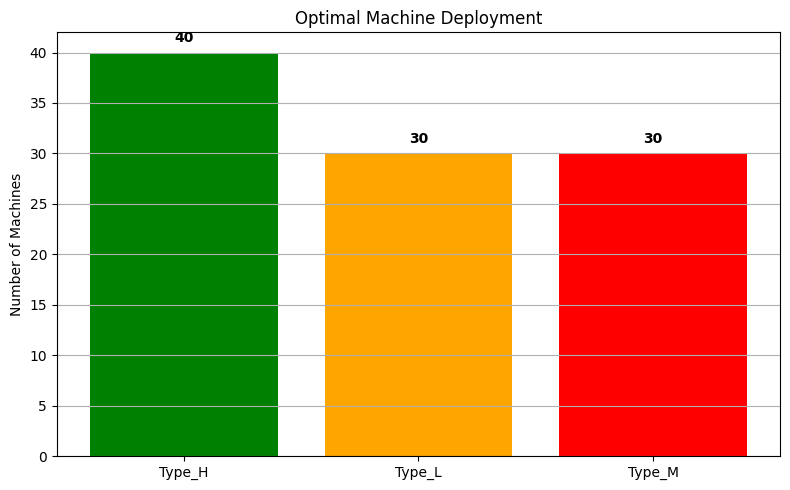

In [14]:
deployment = {
    'Type_H': x_H.value(),
    'Type_L': x_L.value(),
    'Type_M': x_M.value()
}
# Optimal Deployment Plot
plt.figure(figsize=(8, 5))
plt.bar(deployment.keys(), deployment.values(), color=['green', 'orange', 'red'])
plt.title("Optimal Machine Deployment")
plt.ylabel("Number of Machines")
plt.grid(axis='y')
for i, v in enumerate(deployment.values()):
    plt.text(i, v + 1, f"{int(v)}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

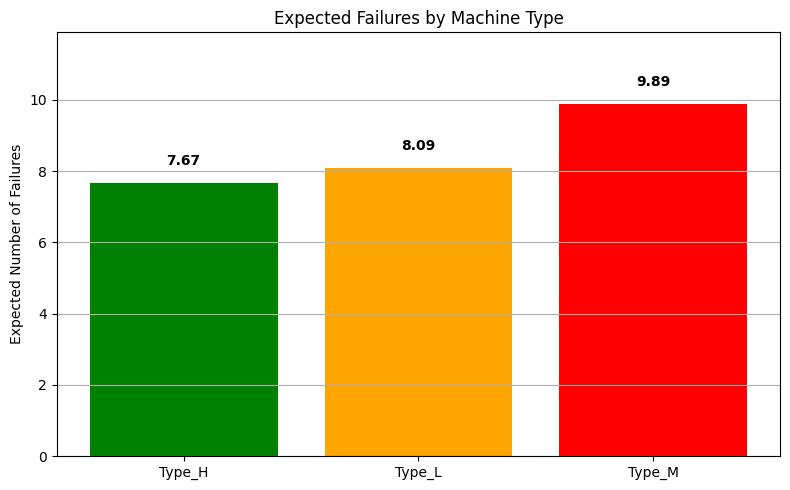

In [15]:
# Compute expected failures per machine type
fail_prob = {
    'Type_H': 0.1917,
    'Type_L': 0.2698,
    'Type_M': 0.3297
}

expected_failures = {
    'Type_H': x_H.value() * fail_prob['Type_H'],
    'Type_L': x_L.value() * fail_prob['Type_L'],
    'Type_M': x_M.value() * fail_prob['Type_M']
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(expected_failures.keys(), expected_failures.values(), color=['green', 'orange', 'red'])
plt.title("Expected Failures by Machine Type")
plt.ylabel("Expected Number of Failures")
plt.ylim(0, max(expected_failures.values()) + 2)
plt.grid(axis='y')
for i, v in enumerate(expected_failures.values()):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


## Deployment Summary Table

In [16]:
summary_df = pd.DataFrame({
    "Machine Type": list(deployment.keys()),
    "Deployed": list(deployment.values()),
    "Failure Probability": [fail_prob[t] for t in deployment],
    "Expected Failures": list(expected_failures.values())
})
summary_df

,Machine Type,Deployed,Failure Probability,Expected Failures
0,Type_H,40.0,0.1917,7.668
1,Type_L,30.0,0.2698,8.094
2,Type_M,30.0,0.3297,9.891
